# Inference a real model

How to inference a real model trainned by another framework like tensorflow/pytorch/PDPD?

Assume the model is supported by OpenVINO, here is the process of running inference using 
This is little complex in OpenVINO, offline conversion(model optimizer)

## Download onnx model

```bash
wget https://media.githubusercontent.com/media/onnx/models/main/vision/classification/resnet/model/resnet18-v1-7.tar.gz
tar -xf resnet18-v1-7.tar.gz
```

## Read the model

In [38]:
from openvino.preprocess import PrePostProcessor
import openvino.runtime as ov
import numpy as np
import time
from pandas import DataFrame
from graphviz import Digraph, Source
import ovhelper

core = ov.Core()

model = core.read_model("./resnet18-v1-7/resnet18-v1-7.onnx")

# uncomment following line to inspect the model topology
# ovhelper.print_model(model)

Very convenient, now lets compile it into CPU runtime model.

In [39]:
device = 'CPU'
# enable PERF_COUNT
core.set_property(device, {"PERF_COUNT": "YES"})

compiled_model = core.compile_model(model, device)

for k, input in enumerate(compiled_model.inputs):
    print("inputs[{}]: {}".format(k,input))
for k, output in enumerate(compiled_model.outputs):
    print("outputs[{}]: {}".format(k,output))

# uncomment following line if you want to check the runtime model in detail
# rt_model = compiled_model.get_runtime_model()
# ovhelper.visualize_model(rt_model)

inputs[0]: <ConstOutput: names[data] shape{1,3,224,224} type: f32>
outputs[0]: <ConstOutput: names[resnetv15_dense0_fwd] shape{1,1000} type: f32>


We saw a lot of optimization is going around here, including:
 - mapping from ngraph OP to CPU plugin OP
 - fusion of adjacent layers

And all these are done automatically, w/o human intervention, this is the best situation. not we can run inference with it

## Tune performance

Please read following docs for detailed guidline:
https://docs.openvino.ai/2021.3/openvino_docs_optimization_guide_dldt_optimization_guide.html

num_request=1: time_used=3.4 sec, fps=290.0, cpu_usage=44.6%
num_request=8: time_used=3.0 sec, fps=337.0, cpu_usage=48.5%


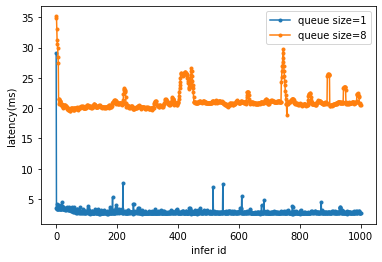

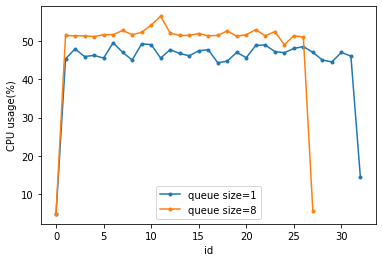

In [40]:
def test_infer_queue(num_request, num_infer, NUM_STREAMS=None, percpu=False):
    if (NUM_STREAMS):
        core.set_property(device, {"NUM_STREAMS":NUM_STREAMS})
    
    # recompile model each time for property to take effect
    compiled_model = core.compile_model(model, device)

    infer_queue = ov.AsyncInferQueue(compiled_model, num_request)
    cpu_usage = ovhelper.CPUUsage()
    inode = compiled_model.input(0)

    latency_list = []
    prof_list = []
    def callback(request, userdata):
        id = userdata
        latency_list.append(request.latency)
        prof_list.append(request.profiling_info)

    infer_queue.set_callback(callback)

    cpu_usage.start(percpu)
    t0 = time.time()
    for i in range(num_infer):
        input = ov.Tensor(inode.get_element_type(), inode.get_shape())
        input.data[:] = i
        infer_queue.start_async({0: input}, userdata=i)
    infer_queue.wait_all()
    cpu = cpu_usage.end()
    wtime = time.time() - t0
    fps = num_infer/wtime
    return latency_list, prof_list, fps, wtime, cpu

import matplotlib.pyplot as plt

NRlist=[1, 8]
TestResult={}
for num_request in NRlist:
    TestResult[num_request] = test_infer_queue(num_request, 1000)
    latency_list, prof_list, fps, wtime, cpu = TestResult[num_request]
    print("num_request={}: time_used={:.1f} sec, fps={:.1f}, cpu_usage={:.1f}%".format(
                        num_request,
                        wtime,
                        fps, 
                        sum(cpu)/len(cpu)))

def visualize_TestResult(TestResult):
    fig, ax = plt.subplots()
    for num_request, (latency_list, prof_list, fps, wtime, cpu) in TestResult.items():
        ax.plot(latency_list, '.-', label="queue size={}".format(num_request))
    plt.ylabel("latency(ms)")
    plt.xlabel("infer id")
    plt.legend()
    plt.show()

    fig, ax = plt.subplots()
    for num_request, (latency_list, prof_list, fps, wtime, cpu) in TestResult.items():
        ax.plot(cpu, '.-', label="queue size={}".format(num_request))
    plt.ylabel("CPU usage(%)")
    plt.xlabel("id")
    plt.legend()
    plt.show()

visualize_TestResult(TestResult)

The test result is quite supprising:
 - `num_request=8` case has slightly higher performance than `num_request=1` case;
 - `num_request=8` case has slightly higher total cpu usage than `num_request=1` case;
 - `num_request=8` case has about 7~8 times more latency than `num_request=1` case;

the total CPU usage is around ~50%, this is reasonable since the server with 2 NUMA nodes and `NUM_STREAMS` property of CPU device is set to 1 by default and execution stream do not cross over NUMA nodes.

In [41]:
print("RANGE_FOR_STREAMS: {}".format(core.get_property(device, "RANGE_FOR_STREAMS")))
print("NUM_STREAMS: {}".format(core.get_property(device, "NUM_STREAMS")))

RANGE_FOR_STREAMS: (1, 88)
NUM_STREAMS: 1


Further check the profiling result we still see no differences:

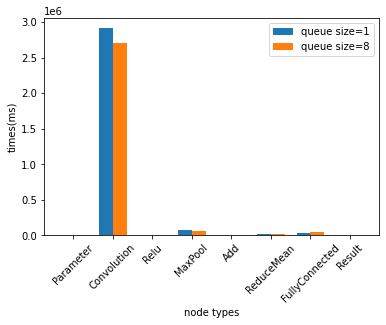

In [42]:
def visualize_profiling(TestResult):
    fig, ax = plt.subplots()
    width = 0.35  # the width of the bars
    dw = width
    for num_request, (latency_list, prof_list, _,_,_) in TestResult.items():
        node_type_times = {}
        for prof in prof_list:
            for p in prof:
                if (p.node_type not in node_type_times):
                    node_type_times[p.node_type] = 0
                node_type_times[p.node_type] += p.real_time.total_seconds()*1e6
        types = []
        times = []
        for k,v in node_type_times.items():
            types.append(k)
            times.append(v)
        x = np.arange(len(types))  # the label locations
        ax.bar(x-dw/2, times, width, label="queue size={}".format(num_request))
        dw = -dw

    ax.set_ylabel("times(ms)")
    ax.set_xlabel("node types")
    ax.set_xticks(x)
    ax.set_xticklabels(types, rotation=45)
    plt.legend()
    plt.show()

visualize_profiling(TestResult)

The fact is, although infer requests are submitted into the execution streams asynchronously, but there is only one execution stream (`NUM_STREAMS` is 1) which is capable of doing only one inference at a time, so latency of 8 infer requests are about 8x of the latency of 1 infer request case beacause each infer request has to wait for other 7 requests to finish before being actually executed by the execution stream.

So when NUM_STREAMS is 1 (which is refered to as `Conventional approach` in [openvino_docs_optimization_guide_dldt_optimization_guide.html](https://docs.openvino.ai/2021.3/openvino_docs_optimization_guide_dldt_optimization_guide.html)), multiple infer requests doesn't bring any performance advantage in terms of inferencing task.

But `num_request=8` case still introduced a little improvement in fps, that's because extra infer request allows the pre-processing part of code in python to be run in parallel with the inferencing of previous infer request, and if there is only 1 infer request, the preprocessing and inferencing can only be run in series.

Now let's try `Throughput-oriented approach` by setting `NUM_STREAMS` to 8 and do the same test again, be aware that you have to re-compile the model for any property changes to take effect:

num_request=1: time_used=22.5 sec, fps=44.4, cpu_usage=7.6%
num_request=8: time_used=2.0 sec, fps=487.9, cpu_usage=40.8%


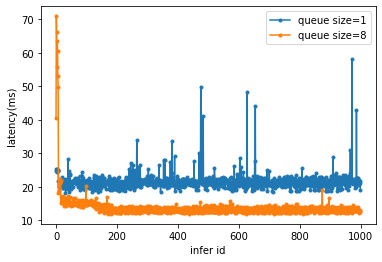

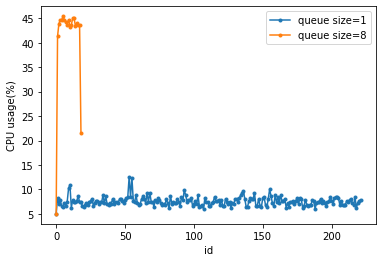

In [43]:
NRlist=[1, 8]
TestResult={}
for num_request in NRlist:
    TestResult[num_request] = test_infer_queue(num_request, 1000, NUM_STREAMS=8)
    latency_list, prof_list, fps, wtime, cpu = TestResult[num_request]
    print("num_request={}: time_used={:.1f} sec, fps={:.1f}, cpu_usage={:.1f}%".format(
                        num_request,
                        wtime,
                        fps, 
                        sum(cpu)/len(cpu)))
visualize_TestResult(TestResult)

And we saw very different result in this case:
 - the `num_request=8, NUM_STREAMS=8` case achieves siginificant higher FPS comparing to `num_request=8, NUM_STREAMS=1` case with even lower cpu usage. As exaplained in `openvino_docs_optimization_guide_dldt_optimization_guide.html`, this is due to:
  > Less threads per stream => less sync, better locality, finer granularity
  
  > "Parallelize the outermost loop" rule of thumb

 - the `num_request=1` case took 7x~8x more times to finish, because now 1 infer request can only be executed on 1/8 resources (all resources are evenly distributed/allocated exclusively to each execution stream).
 - the `num_request=1` case took only about the cpu usage about 1/5 of the `num_request=8` case, in theory it should be 1/8.


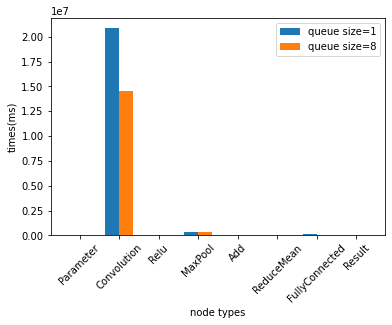

In [44]:
visualize_profiling(TestResult)

## Why only half of the CPU cores are used, even we use 8 as NUM_STREAMS?

NUM_STREAMS=1 num_request=1: time_used=3.5 sec, fps=287.8


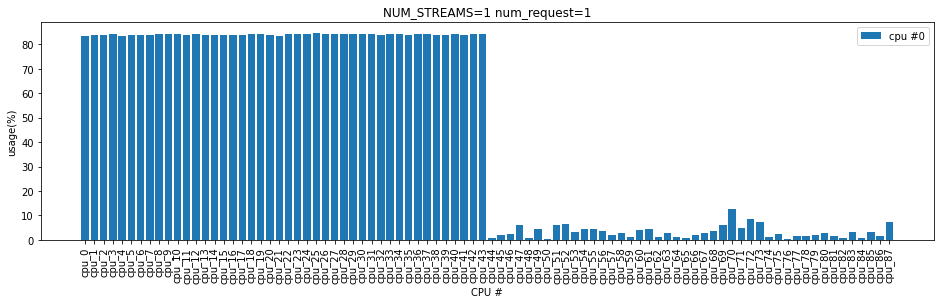

NUM_STREAMS=1 num_request=8: time_used=3.1 sec, fps=326.3


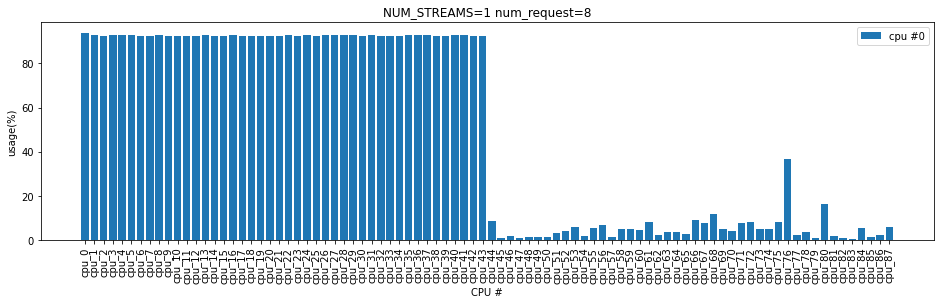

NUM_STREAMS=8 num_request=1: time_used=22.1 sec, fps=45.3


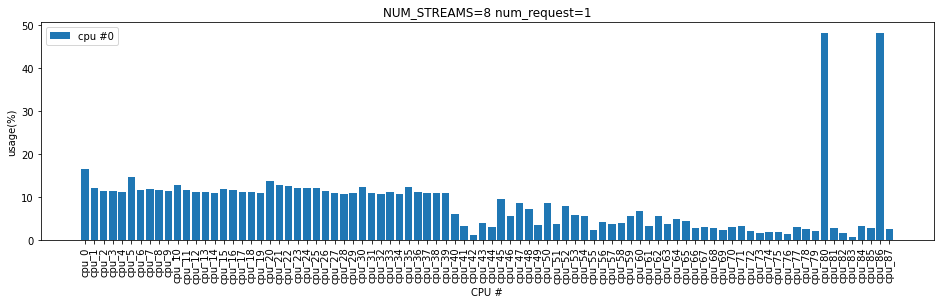

NUM_STREAMS=8 num_request=8: time_used=2.1 sec, fps=472.0


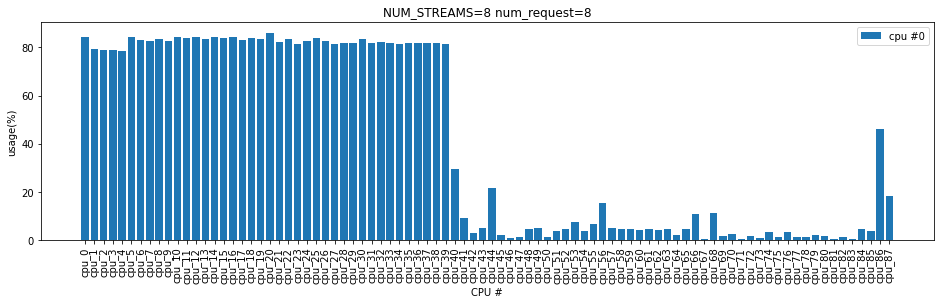

In [45]:
def test_cpu_usage(NUM_STREAMS, num_request):
    latency_list, prof_list, fps, wtime, cpu = test_infer_queue(
                    num_request,
                    1000,
                    NUM_STREAMS=NUM_STREAMS,
                    percpu=True)
    print("NUM_STREAMS={} num_request={}: time_used={:.1f} sec, fps={:.1f}".format(
                        NUM_STREAMS,
                        num_request,
                        wtime,
                        fps))
    cpu_usage = np.array(cpu)

    fig, ax = plt.subplots(figsize=(16,4))
    x = range(cpu_usage.shape[1])
    ax.bar(x, np.mean(cpu_usage, axis=0), label="cpu #{}".format(k))
    ax.set_xlabel("CPU #")
    ax.set_ylabel("usage(%)")
    ax.set_xticks(x)
    ax.set_xticklabels(["cpu_{}".format(num) for num in x], rotation=90)
    ax.set_title("NUM_STREAMS={} num_request={}".format(NUM_STREAMS,num_request))
    plt.legend()
    plt.show()
    #visualize_TestResult(TestResult)

test_cpu_usage(1, 1)
test_cpu_usage(1, 8)
test_cpu_usage(8, 1)
test_cpu_usage(8, 8)

Due to the way linux allocate CPU index to the cores, you may have a misconception that only the first NUMA node is used, even for `NUM_STREAMS=8 num_request=8` case, but actually both NUMA cores are used, even for `NUM_STREAMS=1 num_request=1` case.

Here is what `lscpu` shows:

```bash
CPU(s):              88
On-line CPU(s) list: 0-87
Thread(s) per core:  2
Core(s) per socket:  22
Socket(s):           2
NUMA node(s):        2
...
NUMA node0 CPU(s):   0-21,44-65
NUMA node1 CPU(s):   22-43,66-87
...
```

So we can see actually core 0-43 are from both NUMA nodes, and cores 44-87 are actually Hyperthreads of both NUMA nodes.

That also explains why `NUM_STREAMS=44` is very close to (or even better than) `NUM_STREAMS=88` in terms of performance. 

NUM_STREAMS=44 num_request=44: time_used=1.9 sec, fps=519.2


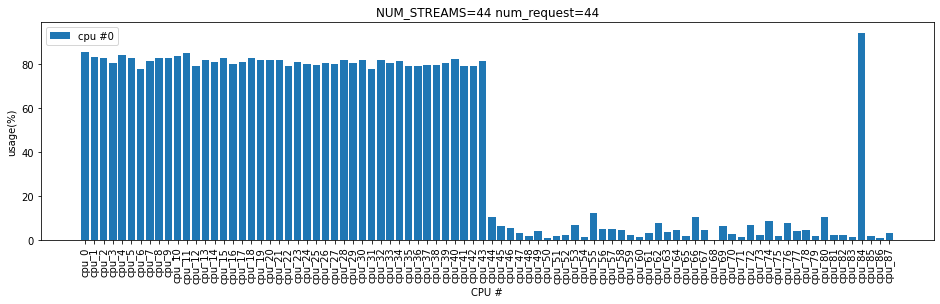

NUM_STREAMS=88 num_request=88: time_used=2.0 sec, fps=491.2


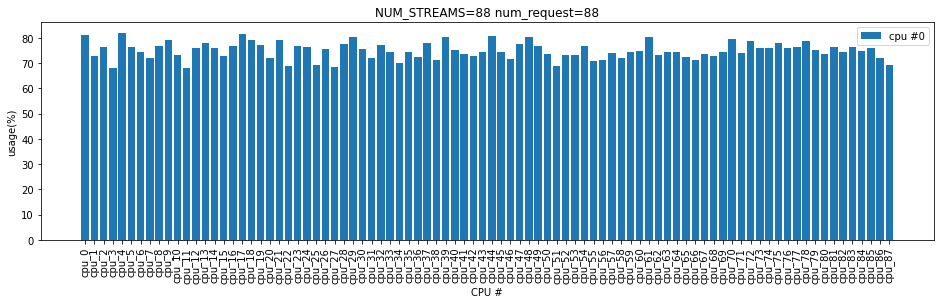

In [46]:
test_cpu_usage(44, 44)
test_cpu_usage(88, 88)

So to achieve highest performance possible, we set NUM_STREAMS to number of physical cores and set high enough num_request to feed data into them.

NUM_STREAMS=44 num_request=88: time_used=1.8 sec, fps=544.9


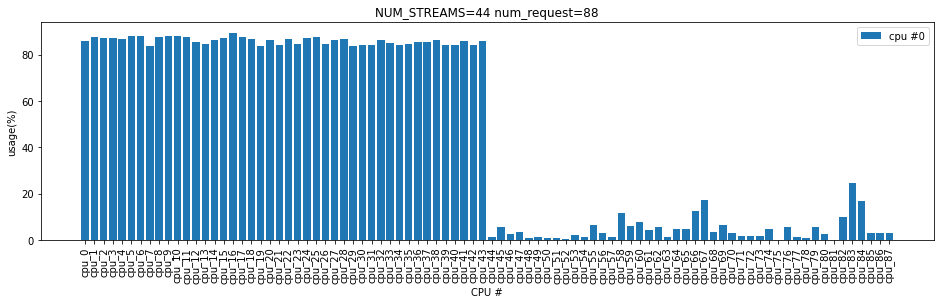

In [47]:
test_cpu_usage(44, 88)